# Reinforcement Learning

In Reinforcement Learning (RL), the model learn through experience, there is no training like in other models in machine learning, instead the model learns using a reward-penalty system; for each good decision the model receives a reward, and for each bad decision, the model is penalized. Perhaps the tricky part is to define how to measure if an action is good or bad.

We will use GYM for this example, this librart provides different learning environments to try our RL models. A common environment is the CartPole, which consists in a cart with a pole, the cart can move left or right and the goal is to keep the pole balanced, if the pole falls, the game is over.

In [1]:
import gym

env = gym.make("CartPole-v1", render_mode="rgb_array")
obs, info = env.reset(seed=42)
obs

array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32)

A cart consists of four values: The position of the pole, its velocity, the pole's angle, and the angular velocity.

We call the `reset` method to initialize our environment.

The function `plot_environment` helps us to plot the environment as an image.

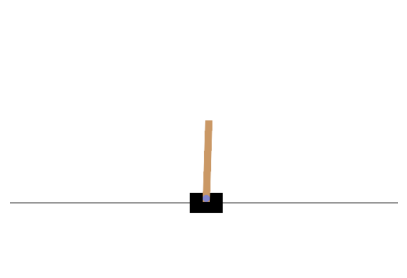

In [2]:
# extra code – creates a little function to render and plot an environment
import matplotlib.animation
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('animation', html='jshtml')

def plot_environment(env, figsize=(5, 4)):
    plt.figure(figsize=figsize)
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    return img

plot_environment(env)
plt.show()

The `action_space` property indicates degree of freedom that we have, in this case is two, moving left and moving right.

In [3]:
env.action_space

Discrete(2)

Let's make a single action, which consists of moving right.

From the `step` method we receive the following:

* `obs`. The new values of the cart (4 integers)
* `reward`. The reward obtained after executing the action.
* `done`. A boolean value indicating if the game is over.
* `truncated`. A boolean value indicating if the game is interrupted early. For example, when a time limit is reached

In [4]:
action = 1  # accelerate right
obs, reward, done, truncated, info = env.step(action)
obs

array([ 0.02727336,  0.18847767,  0.03625453, -0.26141977], dtype=float32)

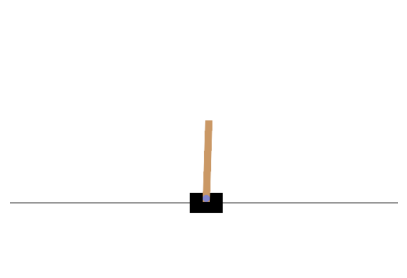

In [5]:
# extra code – displays the environment
plot_environment(env)
plt.show()

In [6]:
reward

1.0

In [7]:
done

False

In [8]:
truncated

False

In [9]:
info

{}

The decisions taken are based on what we called, a policy. A simple policy is to move left when the pole's angle is smaller than 0, otherwise, move right.

Let's simulate multiple games and keep track of the total reward in each game. 

In [10]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(500):
    episode_rewards = 0
    obs, info = env.reset(seed=episode)
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        episode_rewards += reward
        if done or truncated:
            break

    totals.append(episode_rewards)

Let's calculate some statistics for the rewards.

In general, good decisions were made, but that doesn't means that our policy is good. If we visualize one game we can notice that the pole is not balanced at all, and it falls after few actions.

The `update_scene` and `plot_animations` methods are used for displaying animations. The `show_one_episode` simulates a game with a given policy and diplay the animation of the game.

In [11]:
import numpy as np

np.mean(totals), np.std(totals), min(totals), max(totals)

(41.698, 8.389445512070509, 24.0, 63.0)

In [12]:
# extra code – this cell displays an animation of one episode

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

def show_one_episode(policy, n_max_steps=300, seed=42):
    frames = []
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    np.random.seed(seed)
    obs, info = env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render())
        action = policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        if done or truncated:
            break
    env.close()
    return plot_animation(frames)

show_one_episode(basic_policy)

## NN Policy

Now we will use a neural network as a policy. The NN will learn with each game.

Since we only have two possible actions we will a Sigmoid activation function for out output layer, the result will be the probability of moving left.

We will use network with two layers, the first wuth five neurons, and the last one is the output layer with a single neuron and a sigmoid activation function.

In [13]:
import tensorflow as tf

tf.random.set_seed(42)  # extra code – ensures reproducibility on the CPU
n_inputs = 4

model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation="relu", input_shape=[n_inputs]),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

The policy is the output from our NN, 0 for turning left and 1 for turning right. It is essential to mention that we don't execute the action with the highest probability; instead, we select the action according to its probabilities; this is crucial for the correct functionality of the model. 

In [14]:
# extra code – a function that creates an animation for a given policy model

def pg_policy(obs):
    left_proba = model.predict(obs[np.newaxis], verbose=0)
    return int(np.random.rand() > left_proba)

np.random.seed(42)
show_one_episode(pg_policy)

2023-06-01 22:58:04.158302: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


The result is better, but not great. Next, we will use Policy gradients, we will estimate the gradients to make decisions.

## Policy Gradients

Tensorflows allows to define how gradients are estimated with the `GradientTape` method. Remeber that a gradient is estimated by:

$$
f'(x) = \frac{f(x + \epsilon) - f(x)}{\epsilon}
$$

In [15]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))

    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, truncated, info = env.step(int(action))
    return obs, reward, done, truncated, grads

The `play_one_step` method executes one action and returns the gradients along with the output from the `step` method.

Next, we simulate multiple games and keep track of the rewards and gradients. 

In [16]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs, info = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, truncated, grads = play_one_step(
                env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done or truncated:
                break

        all_rewards.append(current_rewards)
        all_grads.append(current_grads)

    return all_rewards, all_grads

The `discount_rewards` methods sum all the rewards multiplied by a discount factor, penalizing newer rewards more.

The `discount_and_normalize_rewards` method, call the `discount_rewards` method and standarizes the result. 

In [17]:
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_factor
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

In [18]:
discount_rewards([10, 0, -50], discount_factor=0.8)

array([-22, -40, -50])

In [19]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]],
                               discount_factor=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

A discount factor of 1 indicates that all rewards will be added without change. While a discount factor of 0 indicates that only the last reward influence in the result.

As before, our NN is a two layer network, with output layer with a sigmoid activation function specifying the probabilities of both possible actions. 

In [20]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.95

In [21]:
tf.random.set_seed(42)
n_inputs = 4

model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation="relu", input_shape=[n_inputs]),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

obs, info = env.reset(seed=42)

In [22]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = tf.keras.losses.binary_crossentropy

We simulate multiple games; for example, 10 games, we keep track of the gradients of these 10 games and then we update the model's gradientes with the results. Basically we multiply the gradients by the standarized rewards and then update the model. We repeat the proces multiple times, and each time the model will learn more.

In [23]:
for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)

    # extra code – displays some debug info during training
    total_rewards = sum(map(sum, all_rewards))
    print(f"\rIteration: {iteration + 1}/{n_iterations},"
          f" mean rewards: {total_rewards / n_episodes_per_update:.1f}", end="")

    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_factor)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)

    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

Iteration: 150/150, mean rewards: 180.4

We use the same policy as before, let it chose randomly the action according to their probabilities.

In [24]:
# extra code – displays the animation
np.random.seed(42)
show_one_episode(pg_policy)